In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime

cudnn.benchmark = True
plt.ion()   # interactive mode

# Fix for a bug that sometimes appeared using matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Check if graphics card is available for model training (it wasn't for a long time)
print(torch.cuda.is_available())

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Directory of 'train' and 'test' folders
data_dir = "C:/Users/Jan/Desktop/XRAY/chest_xray/chest_xrayEqualImages/"

# Retrieving the images by folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Get class names by reading folder names
class_names = image_datasets['train'].classes

# Select graphics card if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Check data type (for test purposes)
print(image_datasets['train'])

Dataset ImageFolder
    Number of datapoints: 2660
    Root location: C:/Users/Jan/Desktop/XRAY/chest_xray/chest_xrayEqualImages/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


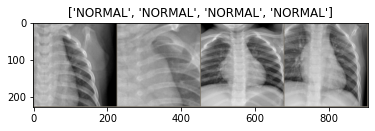

In [5]:
# Method for verifying correct loading of the images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
out.to(device)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
# Method for training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# Method for visualizing model predictions (only categorical, GradCAM visualization further down)
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs.requires_grad=True
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    if num_images == 1:
                        return inputs, labels
                    return
        model.train(mode=was_training)

In [8]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
def test_model(model,dataloaders,device):
    CM=0
    model.eval()
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1])
            
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matrix : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()
                
    return acc, CM

In [9]:
# Get pretrained ResNET18 model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

# Let graphics card handle model
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6708 Acc: 0.7560
test Loss: 0.2652 Acc: 0.8889

Epoch 2/25
----------
train Loss: 0.4712 Acc: 0.8169
test Loss: 0.2503 Acc: 0.8953

Epoch 3/25
----------
train Loss: 0.4764 Acc: 0.8124
test Loss: 0.2016 Acc: 0.9274

Epoch 4/25
----------
train Loss: 0.4226 Acc: 0.8286
test Loss: 0.4355 Acc: 0.7970

Epoch 5/25
----------
train Loss: 0.3755 Acc: 0.8586
test Loss: 0.2732 Acc: 0.8889

Epoch 6/25
----------
train Loss: 0.3608 Acc: 0.8658
test Loss: 0.2067 Acc: 0.9231

Epoch 7/25
----------
train Loss: 0.3188 Acc: 0.8812
test Loss: 0.2213 Acc: 0.9145

Epoch 8/25
----------
train Loss: 0.2327 Acc: 0.9075
test Loss: 0.1913 Acc: 0.9188

Epoch 9/25
----------
train Loss: 0.2199 Acc: 0.9177
test Loss: 0.1739 Acc: 0.9295

Epoch 10/25
----------
train Loss: 0.2190 Acc: 0.9165
test Loss: 0.1495 Acc: 0.9573

Epoch 11/25
----------
train Loss: 0.2034 Acc: 0.9263
test Loss: 0.1683 Acc: 0.9295

Epoch 12/25
----------
train Loss: 0.2094 Acc: 0.9214
test Loss: 0.1624 Ac

In [91]:
test_model(model_ft, dataloaders, device)
# TP | FP
# --------
# FN | TN
# Sensitivity = TP / (TP + FN)
# Specificity = TN / (TN + FP)
# Precision = TP / (TP + FP)
# NPV = TN / (TN + FN))
# F1 =  (2 * Sensitivity * Precision) / (Sensitivity + Precision)


Testset Accuracy(mean): 95.726496 %

Confusion Matrix : 
[[218  16]
 [  4 230]]
- Sensitivity :  98.29059829059828
- Specificity :  93.16239316239316
- Precision:  93.4959349593496
- NPV:  98.1981981981982
- F1 :  95.83333333333333



(0.9572649572649572,
 array([[218,  16],
        [  4, 230]], dtype=int64))

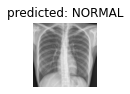

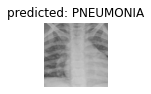

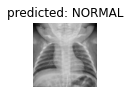

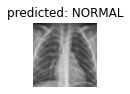

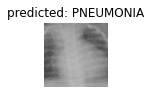

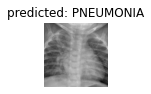

In [92]:
# Visualize model
visualize_model(model_ft)

True Value:  PNEUMONIA
Predicted:  PNEUMONIA


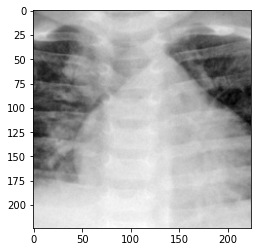

In [93]:
number_of_predictions = 1

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        
        plt.imshow(np.squeeze(images[0][0:1]), cmap='gray')
        
        images = images.to(device)
        labels = labels.to(device)
        
        pred_outputs = model(images)
        predicted = torch.argmax(pred_outputs.data, 1)

print('True Value: ', ' '.join('%s' % class_names[predicted[j]] for j in range(number_of_predictions)))
print('Predicted: ', ' '.join('%s' % class_names[predicted[0]]
                              for j in range(number_of_predictions)))

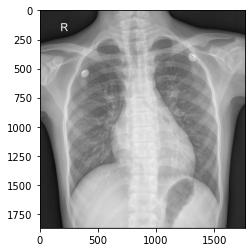

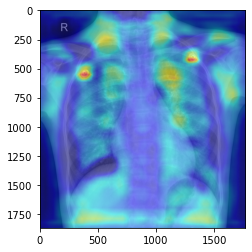

In [109]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
import matplotlib
from PIL import Image
import pytorch_grad_cam.utils.image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import PIL

model = model_ft.to(device)

# Get last convolutional layer of the model
target_layers = [model.layer4[-1]]

# Get any RGB image
#image = PIL.Image.open('C:/Users/Jan/Desktop/XRAY/chest_xray/chest_xrayEqualImages/val/NORMAL/NORMAL2-IM-1430-0001.jpeg')
image = matplotlib.image.imread('C:/Users/Jan/Desktop/XRAY/chest_xray/chest_xrayEqualImages/train/NORMAL/NORMAL2-IM-0559-0001.jpeg')

# Normalize RGB values to values between 0 and 1
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Let graphics card handle input tensor
input_tensor = input_tensor.to(device)

# print image/s
imshow(torchvision.utils.make_grid(input_tensor.cpu()))

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=False)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


plt.imshow(visualization)

plt.imsave("C:/Users/Jan/Desktop/XRAY/GradCAM Images/PyTorchResNet/3each/AUGSMOOTHNORMAL2-IM-0559-0001.jpeg", visualization)

In [113]:
#torch.save(model, "C:/Users/Jan/Desktop/XRAY/FULLRetrainedResNetModel.pth")